## Explore NOAA L2b Wildfire Product (ABI-L2-FDCF)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import datetime 

from wildfire.data import goes_level_1

In [ ]:
import glob

In [3]:

scan = goes_level_1.read_netcdfs(glob.glob("./ABI-L1b-RadF/*/*/*/*.nc"))

In [ ]:
xr.concat(r)

In [ ]:
cced = scan.concatenatecatenate()

In [8]:
band16 = scan["band_16"]
rads = []

x_2km = band16.dataset.x.values
y_2km = band16.dataset.y.values

for _, band in scan.iteritems():
    rads.append(band.normalize().assign_coords(x=x_2km, y=y_2km))
    rads[-1] = rads[-1]

/Users/camen/miniconda/envs/wildfire3.7/lib/python3.7/site-packages/xarray/core/computation.py:603: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [3]:
ds

<xarray.Dataset>
Dimensions:                                           (number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_sunglint_angle_bounds: 2, number_of_time_bounds: 2, x: 2500, y: 1500)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float32 0.128212 ... 0.044268005
  * x                                                 (x) float32 -0.101332 ... 0.038612
    y_image                                           float32 ...
    x_image                                           float32 ...
    sunglint_angle                                    float32 ...
    local_zenith_angle                                float32 ...
    solar_zenith_angle                                float32 ...
Dimensions without coordinates: number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_sunglint_angle_bounds, number_of_time_bounds
Data variables:
    

### Read L2 File

In [21]:
year = 2019
dayofyear = 260
hour = 19

l2_path = f'/nobackupp10/tvandal/data/goes16/ABI-L2-FDCF/{year}/{dayofyear}/{hour}/'

l2_file_path = os.path.join(l2_path, sorted(os.listdir(l2_path))[0])

ds = xr.open_dataset(l2_file_path)
print(ds.attrs['summary'])
print(f"Number of fires: {ds['total_number_of_pixels_with_fires_detected'].values}")

The Fire - Hot Spot Characterization product consists of a fire mask identifying pixels as one of many fire, non-fire, and obstructed view categories. In addition, the product consists of fire temperature,radiative power, and area for valid fire pixels that satisfy specific criteria. This product is generated by utilizing differences in emissive bands with wavelengths 3.89 and 11.19 um to high temperature sub pixel anomalies. Product data is generated both day and night.
Number of fires: 1701.0


In [22]:
ds

<xarray.Dataset>
Dimensions:                                           (number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_sunglint_angle_bounds: 2, number_of_time_bounds: 2, x: 5424, y: 5424)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float32 0.151844 ... -0.151844
  * x                                                 (x) float32 -0.151844 ... 0.151844
    y_image                                           float32 ...
    x_image                                           float32 ...
    sunglint_angle                                    float32 ...
    local_zenith_angle                                float32 ...
    solar_zenith_angle                                float32 ...
Dimensions without coordinates: number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_sunglint_angle_bounds, number_of_time_bounds
Data variables:
    Ar

In [23]:
def extract_patches_2d(arr, height, width, stride):
    assert len(arr.shape) >= 2
    H, W = arr.shape[:2]
    ih = np.arange(0,H,stride)
    iw = np.arange(0,W,stride)
    patches = []
    for i in ih:
        i = min(i, H-height)
        for j in iw:
            j = min(j, W-width)
            patches.append(arr[i:i+height, j:j+height][np.newaxis])
    return np.concatenate(patches)

### Histogram of Fire Temperatures and Random Wildfire Plot

(array([431, 326, 106,  43,  22,  13,   3,   1,   0,   2]), array([ 400.49442,  575.7589 ,  751.0234 ,  926.28784, 1101.5524 ,
       1276.8168 , 1452.0813 , 1627.3457 , 1802.6102 , 1977.8746 ,
       2153.1392 ], dtype=float32))
(542, 16, 16)


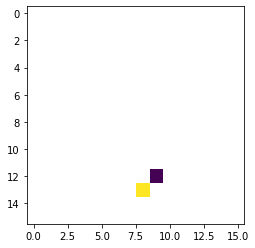

In [24]:
vals = ds.Temp.values
vmin = np.nanmin(vals)
vmax = np.nanmax(vals)
vals_flat = vals.flatten()
vals_flat = vals_flat[np.isfinite(vals_flat)]
print(np.histogram(vals_flat))

patches = extract_patches_2d(vals, 16, 16, 16)
fire_patches = patches[np.any(np.isfinite(patches), axis=(1,2))]
print(fire_patches.shape)
i = np.random.randint(0, len(fire_patches))
plt.imshow(fire_patches[i])

### Read in L1b Radiances

In [26]:
# load scan and get wildfire map
#
l1_dir = f'/nex/datapool/geonex/public/GOES16/NOAA-L1B/ABI-L1b-RadF/{year}/{dayofyear}/{hour}/'
files = [os.path.join(l1_dir, f) for f in sorted(os.listdir(l1_dir))]
filepaths = utilities.group_filepaths_into_scans(files)
goes_scan = scan.read_netcdfs(local_filepaths=filepaths[0])

In [27]:
goes_scan_2km = goes_scan.rescale_to_2km() # this method is misnamed in scan.py
datasets = []
band16 = goes_scan_2km['band_16']
for band, s in goes_scan_2km.iteritems():
    d = s.dataset
    d = d.assign_coords(x=band16.dataset.x.values,
                        y=band16.dataset.y.values)
    datasets.append(d['Rad'])
    
l1ds = xr.concat(datasets, 'band')

### Join L1b and L2 Fire Data and Extract Patches

In [28]:
alldata = np.concatenate([l1ds.values, ds.Temp.values[np.newaxis]], 0)
alldata = np.transpose(alldata, (1,2,0))
alldata_patches = extract_patches_2d(alldata, 16, 16, 16)
print(alldata_patches.shape)

fire_idxs = np.any(np.isfinite(alldata_patches[:,:,:,-1]), axis=(1,2))
alldata_fire_patches = alldata_patches[fire_idxs]
alldata_fire_patches.shape

(114921, 16, 16, 17)


(542, 16, 16, 17)

### Show RGB, Band 15 Temp, and L2 Fire Temp

Text(0.5, 1.0, 'Band 15 - Brightness Temp')

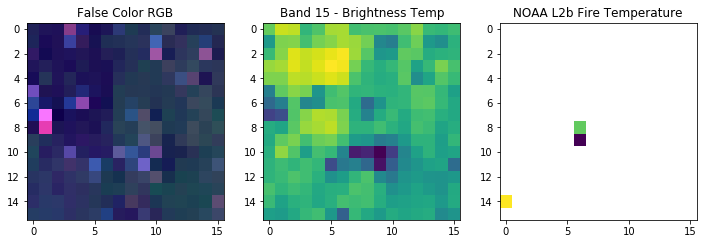

In [29]:
#i = np.random.randint(0, len(alldata_fire_patches))
i = 212

fig, axs = plt.subplots(1,3,figsize=(12,5))
axs = np.ravel(axs)
#[a.axis('off') for a in axs]

axs[2].imshow(alldata_fire_patches[i,:,:,-1])
axs[2].set_title("NOAA L2b Fire Temperature")

rgb = alldata_fire_patches[i,:,:,[1,2,0]]
rgb = np.transpose(rgb, (1,2,0))
mn = np.nanmin(rgb)
mx = np.nanmax(rgb)
rgb = (rgb - mn) / (mx - mn)
axs[0].imshow(rgb)
axs[0].set_title("False Color RGB")

axs[1].imshow(alldata_fire_patches[i,:,:,14])
axs[1].set_title("Band 15 - Brightness Temp")